# SDR Example
This notebook is loosely based on cusignal [sdr_integration](https://github.com/rapidsai/cusignal/blob/branch-21.08/notebooks/sdr/sdr_integration.ipynb) example.

## Reading SDR data
In the cusignal example an instance of RTL-SDR is used to record radio IQ data. Below, a wav file is used for this purpose. Example IQ wav files can be found on the web. If the IQ wav file is not present it is downloaded from www.teske.net.br.

In [1]:
from pathlib import Path

In [2]:
iq_wavefile = 'SDRSharp_20161220_142714Z_1692700000Hz_IQ.wav'
if not Path(iq_wavefile).exists():
    !wget https://www.teske.net.br/lucas/basebands/goes13/emwin/SDRSharp_20161220_142714Z_1692700000Hz_IQ.wav

### Calculating and Plotting Power Spectral Density (PSD)
The Greenflow taskgraph "sdr_example.gq.yaml" loads and IQ signal, produces Welch PSD estimates, does various resampling operations, etc. This taskgraph does what the original cusignal "sdr_integration" notebook demonstrated.

In [3]:
from greenflow.dataframe_flow import (TaskGraph, TaskSpecSchema)

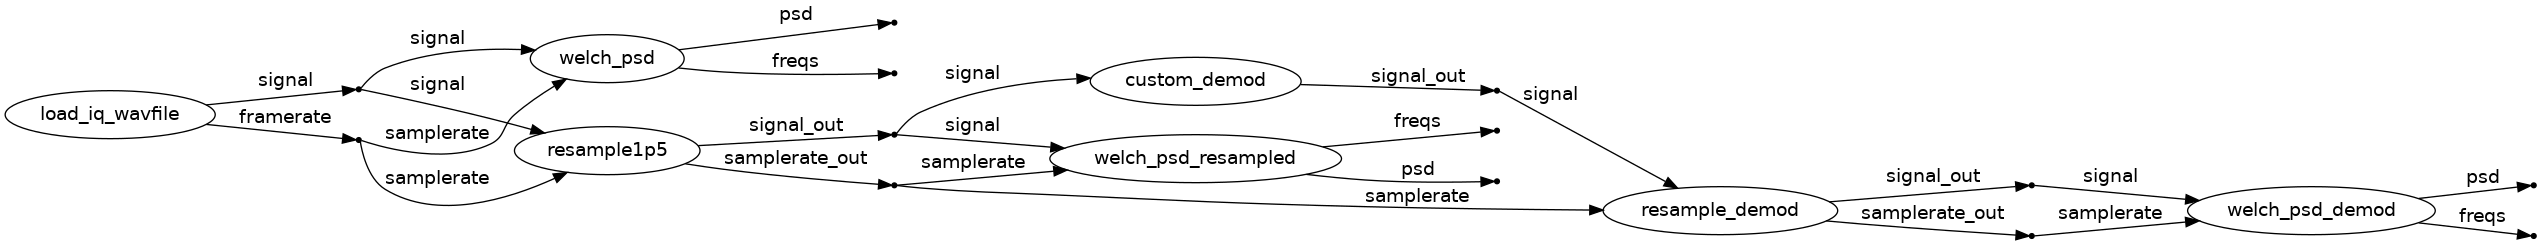

In [4]:
tgraph_sdr = TaskGraph.load_taskgraph('./taskgraphs/sdr_example.gq.yaml')
tgraph_sdr.build()
tgraph_sdr.draw(show='ipynb', show_ports=True, pydot_options={'rankdir': 'LR'})

The whole graph can be run via:
```
outdemod = ['resample_demod.signal_out', 'resample_demod.samplerate_out',
            'welch_psd_demod.psd', 'welch_psd_demod.freqs']
(signal_demod, framerate_demod, psd_demod, freqs_demod) = tgraph_sdr.run(outdemod)
```

That is all that would be required. For illustrative purproses and to compare to the "sdr_integration" notebook from cusignal examples, we run this taskgraph in portions. A subportion of the taskgraph is run by specifying the specific outputs desired, and one can pre-load outputs/inputs. Any operations not required for the specified outputs are not run. Below only tasks "load_iq_wavfile" and "welch_ps" are run, then the Welch output is plotted.

In [5]:
outlist = ['load_iq_wavfile.signal', 'load_iq_wavfile.framerate',
           'welch_psd.psd', 'welch_psd.freqs']
(signal, framerate, psd, freqs) = tgraph_sdr.run(outlist)

Framerate: 156250.0


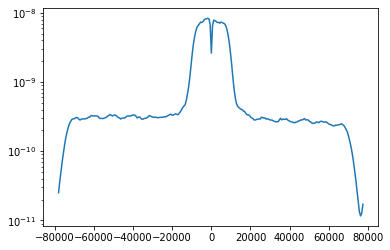

In [6]:
print('Framerate: {}'.format(framerate))

from scipy.fftpack import fftshift
import matplotlib.pyplot as plt

plt.semilogy(fftshift(freqs.get()), fftshift(psd.get()))
plt.show()

### Resampling and GPU to CPU comparison
As an example of some operations we resample the signal. Then compare how long this operation takes via GPU and CPU.

In [7]:
outlist = ['resample1p5.signal_out', 'resample1p5.samplerate_out',
           'welch_psd_resampled.psd', 'welch_psd_resampled.freqs']
(signal_re, framerate_re, psd_re, freqs_re) = tgraph_sdr.run(outlist)

#### Time just the resampler
If we want to time just the resampling portion then we need to pre-load the signal.

In [8]:
signal_gpu = signal
replace_gpu = {
    'load_iq_wavfile': {
        TaskSpecSchema.load: {
            'signal': signal_gpu,
            'framerate': framerate
        }
    }
}
# If using GreenflowLab delete widget for better timing.
# tgraph_sdr.del_widget()
tgraph_sdr.build(replace=replace_gpu)
gpu_time = %timeit -r 7 -n 100 -o (signal_re,) = \
    tgraph_sdr.run(['resample1p5.signal_out'], build=False)

# Now run the CPU equivalent
signal_cpu = signal_gpu.get()
resample1p5_conf_cpu = tgraph_sdr['resample1p5'].conf.copy()
resample1p5_conf_cpu['use_cpu'] = True
replace_cpu = {
    'load_iq_wavfile': {
        TaskSpecSchema.load: {
            'signal': signal_cpu,
            'framerate': framerate            
        }
    },
    'resample1p5': {
        TaskSpecSchema.conf: resample1p5_conf_cpu
    }
}
tgraph_sdr.build(replace=replace_cpu)
cpu_time = %timeit -r 7 -n 10 -o (signal_re,) = \
    tgraph_sdr.run(['resample1p5.signal_out'], build=False)

print('SPEEDUP: {}x'.format(round(cpu_time.average / gpu_time.average, 1)))

# reset the build without replace
tgraph_sdr.build()

3.53 ms ± 47.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
31.2 ms ± 259 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
SPEEDUP: 8.8x


The resulting PSD of resampled signal is shown below.

Resampled Framerate: 234375.0


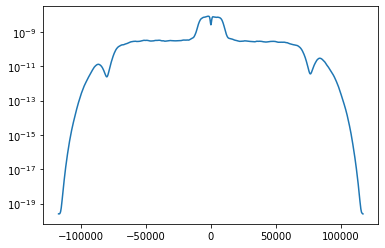

In [9]:
print('Resampled Framerate: {}'.format(framerate_re))

plt.semilogy(fftshift(freqs_re.get()), fftshift(psd_re.get()))
plt.show()

#### Demodulate and profile
Now we can run demodulation and again compare on GPU vs CPU. The demodulation logic is set via custom code in the "custom_demod" task.

In [10]:
tgraph_sdr.build()
print('# Demodulation code')
print(tgraph_sdr['custom_demod'].conf['pycode'])

# Demodulation code
import numpy as np
import cupy as cp

def custom_filter(signal, conf):
    use_cpu = conf.get('use_cpu', False)
    if use_cpu:
        angle_sig = np.unwrap(np.angle(signal))
        demod_sig = np.diff(angle_sig)
    else:
        angle_sig = cp.unwrap(cp.angle(signal))
        demod_sig = cp.diff(angle_sig)
    return demod_sig



In [11]:
outdemod = ['resample_demod.signal_out', 'resample_demod.samplerate_out',
            'welch_psd_demod.psd', 'welch_psd_demod.freqs']
(signal_demod, framerate_demod, psd_demod, freqs_demod) = tgraph_sdr.run(outdemod)

Let's time just the demodulation logic.

In [12]:
# If using GreenflowLab delete widget for better timing.
# tgraph_sdr.del_widget()

# pre-load the resampled signal from above.
replace_gpu = {
    'resample1p5': {
        TaskSpecSchema.load: {
            'signal_out': signal_re,
            'samplerate_out': framerate_re
        }
    }
}
tgraph_sdr.build(replace=replace_gpu)
gpu_time = %timeit -r 7 -n 100 -o (signal_demod,) = \
    tgraph_sdr.run(['resample_demod.signal_out'], build=False)

# Run on CPU
custom_demod_conf_cpu = tgraph_sdr['custom_demod'].conf.copy()
custom_demod_conf_cpu['use_cpu'] = True

resample_demod_conf_cpu = tgraph_sdr['resample_demod'].conf.copy()
resample_demod_conf_cpu['use_cpu'] = True

replace_cpu = {
    'resample1p5': {
        TaskSpecSchema.load: {
            'signal_out': signal_re.get(),
            'samplerate_out': framerate_re
        }
    },
    'custom_demod': {
        TaskSpecSchema.conf: custom_demod_conf_cpu
    },
    'resample_demod': {
        TaskSpecSchema.conf: resample_demod_conf_cpu
    }
}
tgraph_sdr.build(replace=replace_cpu)
cpu_time = %timeit -r 7 -n 10 -o (signal_demod,) = \
    tgraph_sdr.run(['resample_demod.signal_out'], build=False)

print('SPEEDUP: {}x'.format(round(cpu_time.average / gpu_time.average, 1)))


7.79 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
48.1 ms ± 344 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
SPEEDUP: 6.2x


Original framerate 156.250kHz resampled to up = 3 down = 2 => 234.375kHz. Then the demodulation resamples to 48kHz.

Demod Framerate: 48000.0


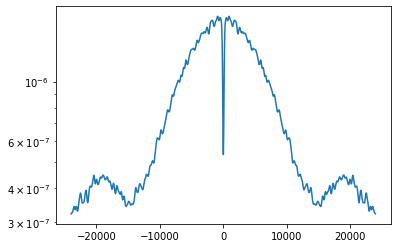

In [13]:
print('Demod Framerate: {}'.format(framerate_demod))
plt.semilogy(fftshift(freqs_demod.get()), fftshift(psd_demod.get()))
plt.show()